In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.8 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.21.3 statsmodels==0.12.0.dev0+57.g693c22e2e python-igraph==0.7.1 louvain==0.6.1


In [4]:
%%R
gc()
rm(list = ls())

# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(lme4)
#library(slingshot)
#library(monocle)
#library(gam)
#library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

# T1D

In [5]:
adata = sc.read_h5ad("h5ad/postQC_t1d.h5ad")
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5,random_state=0)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 15


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(p

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:03)


In [6]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [7]:
input_groups2 = adata_pp.obs["HPAP_id"]

In [8]:
%%R -i data_mat -i input_groups2 -o size_factors
#%%R -i data_mat -i input_groups -o size_factors
# saveRDS(data_mat,"data_mat.rds")
size_factors = computeSumFactors(SingleCellExperiment(list(counts=data_mat)),clusters=input_groups2, min.mean=0.1)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
dataset2Tech = dict(zip(["HPAP-015","HPAP-020","HPAP-021","HPAP-023",
                         "HPAP-032","HPAP-055",'HPAP-036',"HPAP-028",
                         'HPAP-034','HPAP-039','HPAP-042','HPAP-052',
                         "HPAP-012","HPAP-056","HPAP-029","HPAP-024"],
                       ["Fluidigm","10X.2","10X.2","10X.2","10X.2","10X.3","10X.2",
                        "10X.2","10X.2","10X.3","10X.3","10X.3",
                        "Fluidigm","10X.3","10X.3","10X.3"]))
adata.obs["Tech"] = adata.obs["HPAP_id"].map(dataset2Tech)

In [10]:
adata

AnnData object with n_obs × n_vars = 17438 × 31890
    obs: 'HPAP_id', 'Disease', 'Sex', 'Age', 'Race', 'BMI', 'HbA1c', 'AAb+', 'n_genes', 'n_counts', 'percent_mito', 'Barcode', 'batch', 'Tech'
    var: 'gene_symbols', 'EnsGeneID'

... storing 'Tech' as categorical


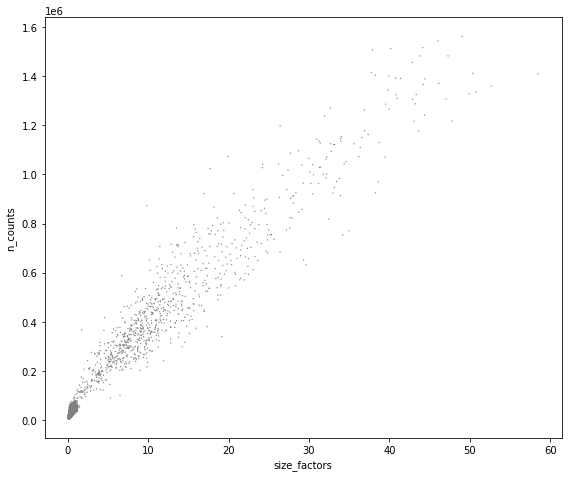

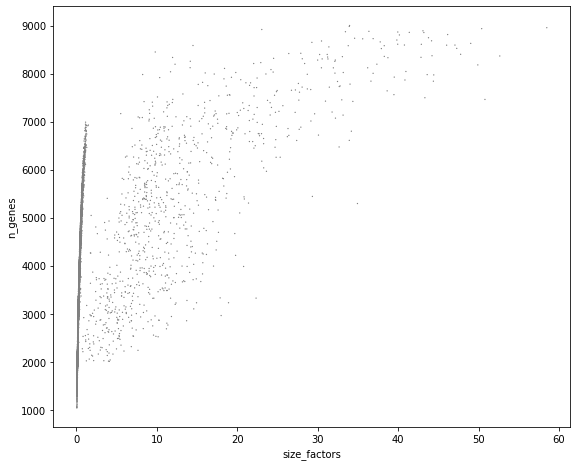

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


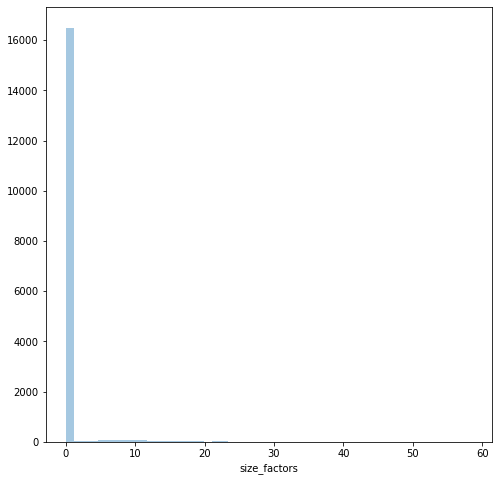

In [11]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors.obs.sizeFactor.values

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(adata.obs['size_factors'], bins=50, kde=False)
plt.show()

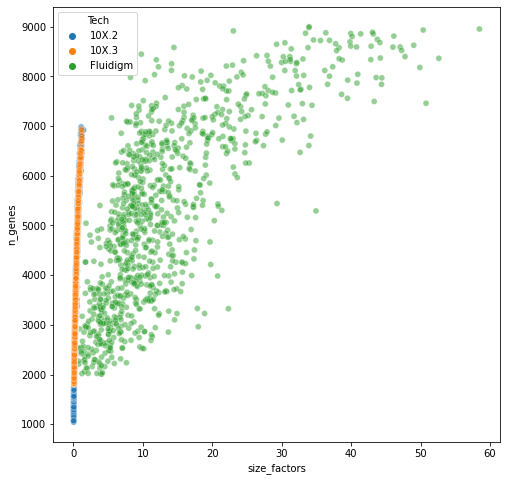

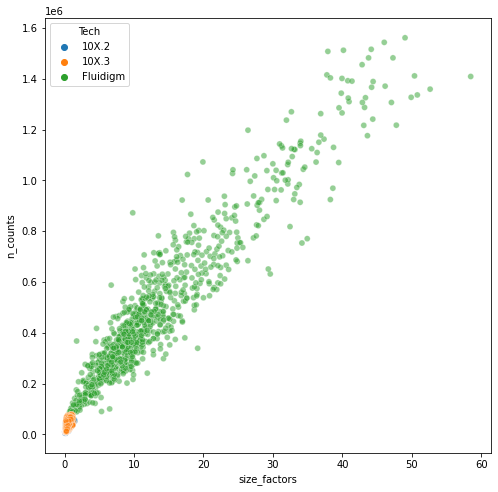

In [12]:
sb.scatterplot(data = adata.obs,x="size_factors",y="n_genes",alpha=0.5,hue="Tech")
plt.show()
sb.scatterplot(data = adata.obs,x="size_factors",y="n_counts",alpha=0.5,hue="Tech")

In [13]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [14]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', 
                            # batch_key = "Tech",
                            n_top_genes=6000)


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [15]:
def adata2bbknnCorrected(adata_,n_top_genes=3500,
                         batch_variable="dataset",res=0.5,
                         confounders=['louvain'],computeHVGs=False):
    adata = adata_.copy()
    # some pp
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # compute hvgs
    if computeHVGs: sc.pp.highly_variable_genes(adata,n_top_genes=n_top_genes,)
                                #batch_key=batch_variable)
    #hvgs = adata.var[adata.var["highly_variable_intersection"]].index.values
    hvgs = adata.var[adata.var["highly_variable"]].index.values
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)    # before/after MNN visualization
    sc.pl.umap(adata,color=["Tech","HPAP_id"])

    # go BBKNN
    bbknn.bbknn(adata, batch_key=batch_variable)
    #sc.tl.umap(adata)
    #sc.pl.umap(adata, color=['Tech', 'dataset'])
    
    #
    sc.tl.louvain(adata,resolution=res)
    bbknn.ridge_regression(adata, batch_key=[batch_variable], confounder_key=confounders)
    sc.pp.pca(adata)
    bbknn.bbknn(adata, batch_key=batch_variable)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['Tech','HPAP_id'])

    return adata

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


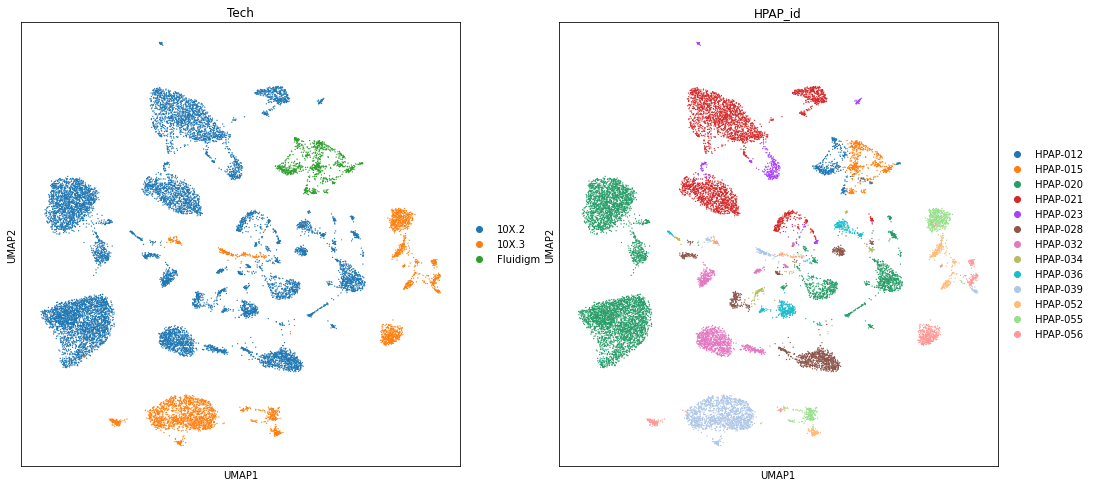

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:12)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


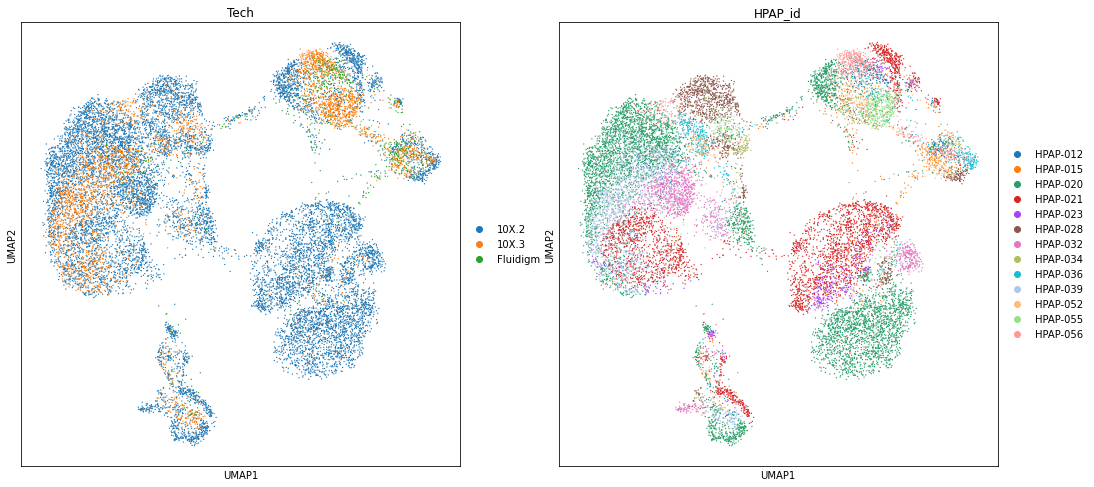

In [16]:
import bbknn
mnn_t1d = adata2bbknnCorrected(adata,6000,"Tech")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


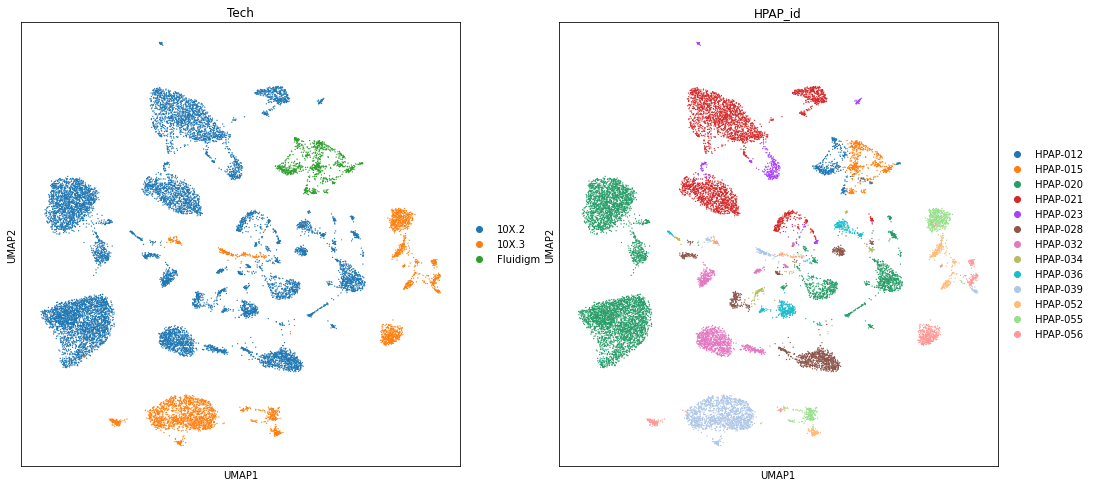

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:10)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


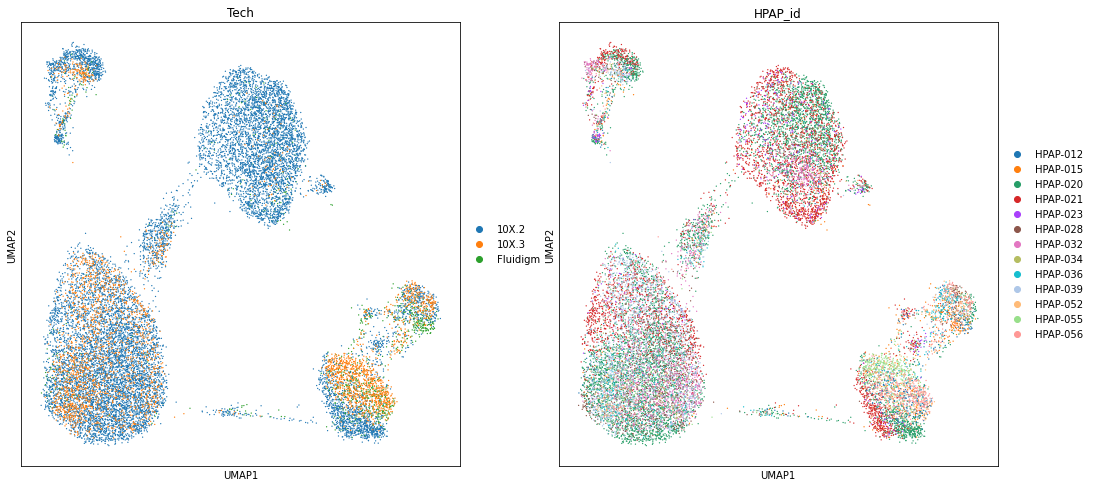

In [44]:
mnn_t1d = adata2bbknnCorrected(adata,6000,"HPAP_id")

to avoid issues related to reproducibility, I load a previously saved object to achieve consistent results in successive iteration of this notebook (and also consistent with the paper results!)

In [53]:
mnn_t1d = sc.read_h5ad("h5ad/adata_t1d.final.h5ad")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


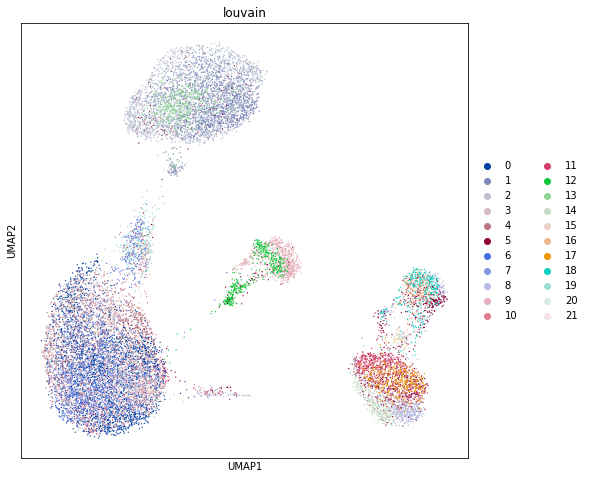

In [54]:
def louvainAndPlot(adata_,res=0.5,**kwargs):
    adata = adata_.copy()
    sc.tl.louvain(adata,resolution=res)
    sc.pl.umap(adata, color='louvain')
mnn_t1d.obsm["umap"] = mnn_t1d.obsm["UMAP"]
sc.pp.pca(mnn_t1d)
sc.pp.neighbors(mnn_t1d)
louvainAndPlot(mnn_t1d,.3)

running Louvain clustering
    finished: found 26 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


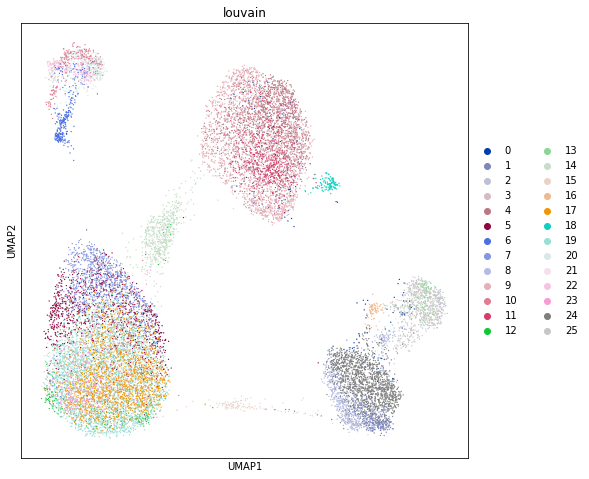

In [52]:
#sc.pp.pca(mnn_t1d)
#sc.pp.neighbors(mnn_t1d)
def louvainAndPlot(adata_,res=0.5,**kwargs):
    adata = adata_.copy()
    sc.tl.louvain(adata,resolution=res,**kwargs)
    sc.pl.umap(adata, color='louvain')

louvainAndPlot(mnn_t1d,.8,flavor="igraph")

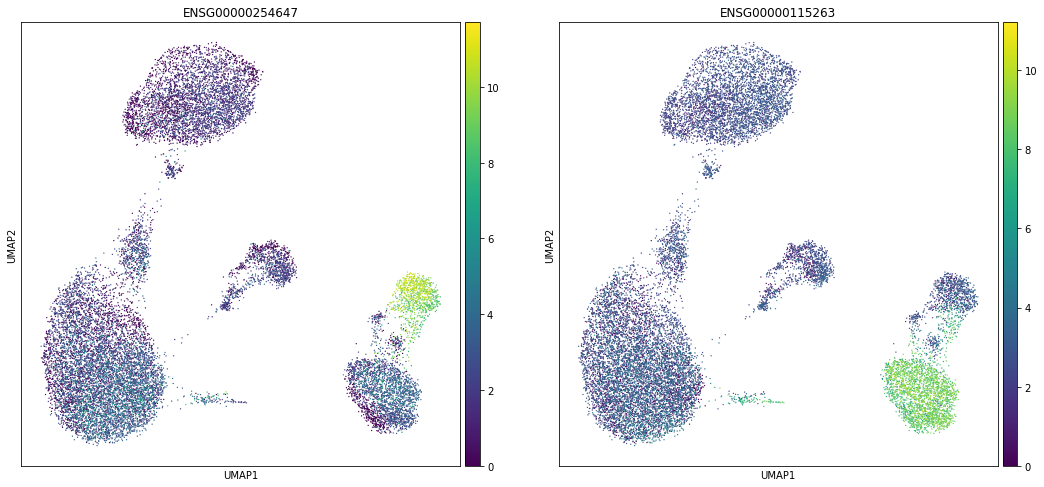

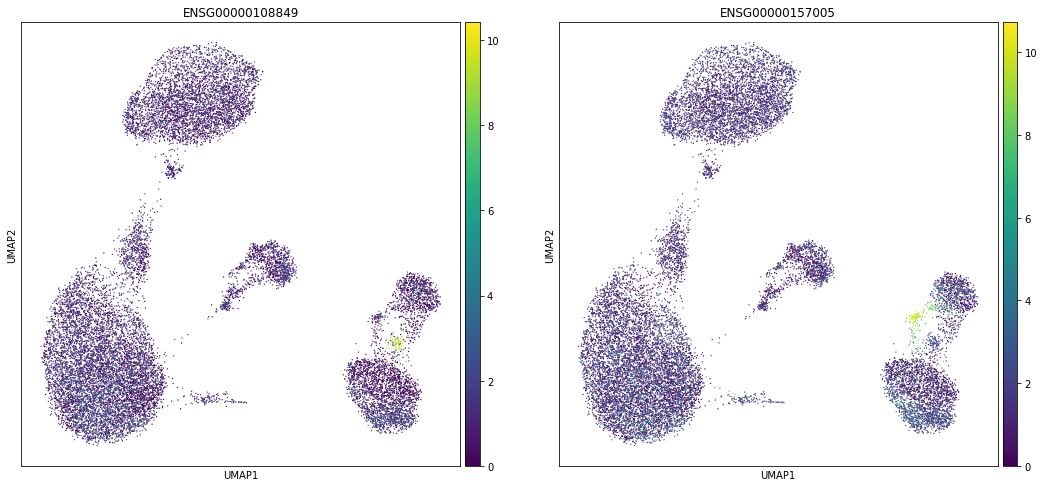

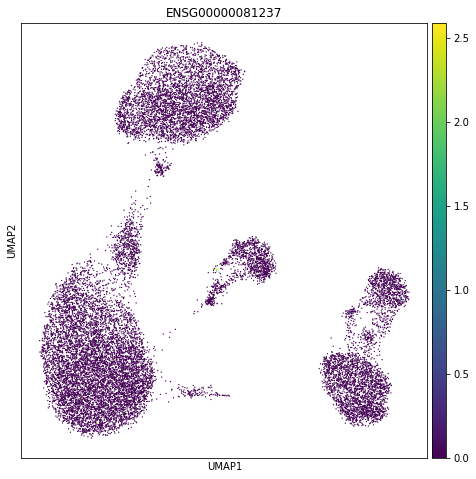

In [55]:
sc.pl.umap(mnn_t1d,color=["ENSG00000254647","ENSG00000115263"])
sc.pl.umap(mnn_t1d,color=["ENSG00000108849","ENSG00000157005"])
sc.pl.umap(mnn_t1d,color=["ENSG00000081237"])


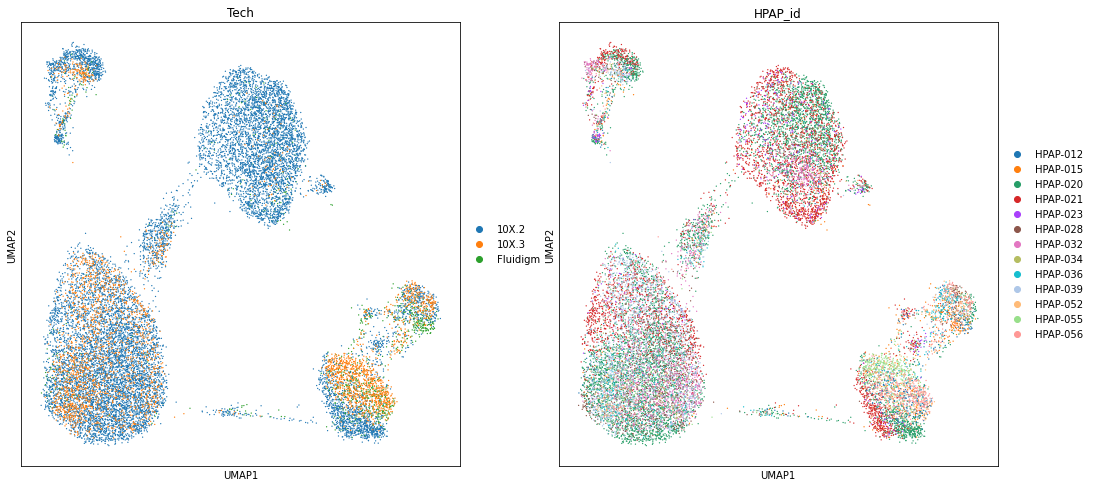

In [32]:
sc.pl.umap(mnn_t1d,color=["Tech","HPAP_id"],save="T1D_confounders.pdf")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell type']`
categories: INS+GCG+, PP, acinar, etc.
var_group_labels: alpha, beta, PP, etc.


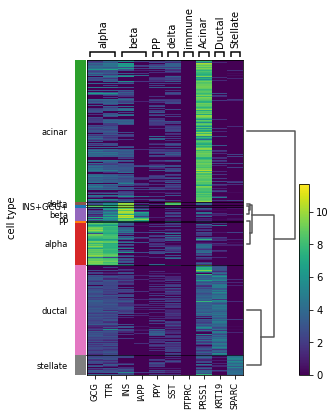

GridSpec(2, 4, height_ratios=[0.15, 6], width_ratios=[0.2, 3.0, 1, 0.2])

In [64]:
cluster2annotation = {i:v for l,v in zip(\
    *([["0","4"], # acinar
       ["1"], # ductal
       ["3"], # stellate
       ["2,0","2,2"], # alpha
       ["2,1,0","2,1,1","2,1,2","2,1,6"], # beta
       ["2,1,4"], # hybrid
       ["2,1,5"], # PP
       ["2,1,3"]], # delta
      ["acinar","ductal","stellate","alpha","beta","INS+GCG+","PP","delta"]))\
                                   for i in l}
mnn_t1d.obs['cell type'] = mnn_t1d.obs['louvain_endo2'].map(cluster2annotation).astype('category')
sc.tl.dendrogram(mnn_t1d,"cell type")
sc.pl.heatmap(mnn_t1d, marker_genes_dict, groupby='cell type', cmap='viridis', 
                   dendrogram=True,gene_symbols="gene_symbols")

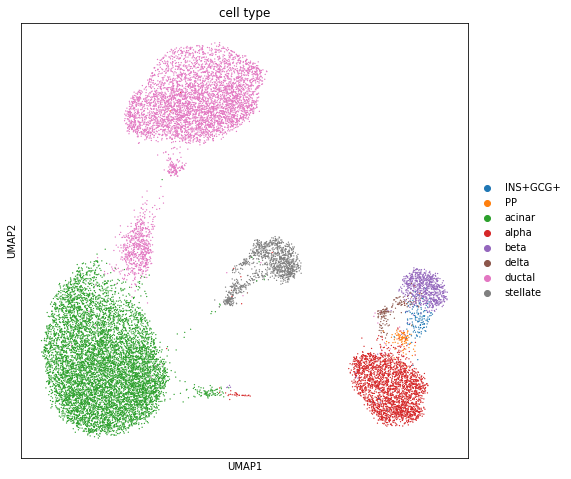

In [67]:
sc.pl.umap(mnn_t1d,color="cell type")

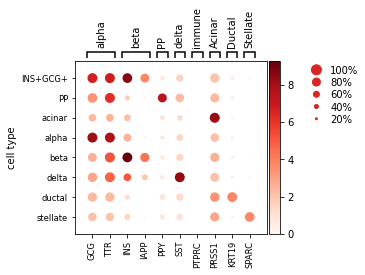

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [69]:
sc.pl.dotplot(mnn_t1d, marker_genes_dict,'cell type',gene_symbols="gene_symbols",save="T1D_cell_type_markers_dotplot.pdf")

In [ ]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test = mnn_t1d.copy()
adata_test.X = mnn_t1d.raw.X
adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

# T2D

In [70]:
adata = sc.read_h5ad("h5ad/postQC_t2d.h5ad")
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5,random_state=0)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [71]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [72]:
input_groups2 = adata_pp.obs["HPAP_id"]

In [73]:
%%R -i data_mat -i input_groups2 -o size_factors
#%%R -i data_mat -i input_groups -o size_factors
# saveRDS(data_mat,"data_mat.rds")
size_factors = computeSumFactors(SingleCellExperiment(list(counts=data_mat)),clusters=input_groups2, min.mean=0.1)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [75]:
dataset2Tech = dict(zip(["HPAP-001","HPAP-007","HPAP-006","HPAP-014",
                         "HPAP-051","HPAP-057",'HPAP-058',"HPAP-053",
                         'HPAP-054','HPAP-059'],
                       ["Fluidigm","Fluidigm","Fluidigm","Fluidigm",
                        "10X.3","10X.3","10X.3","10X.3","10X.3","10X.3"]))
adata.obs["Tech"] = adata.obs["HPAP_id"].map(dataset2Tech)

... storing 'Tech' as categorical


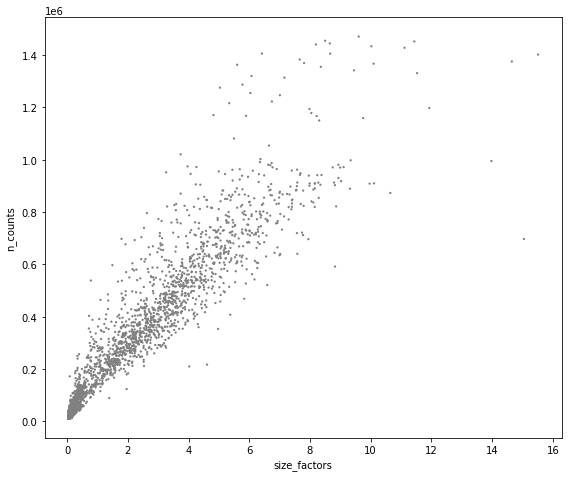

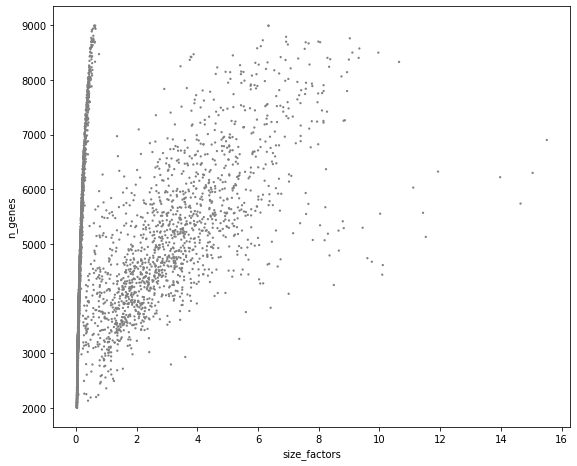

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


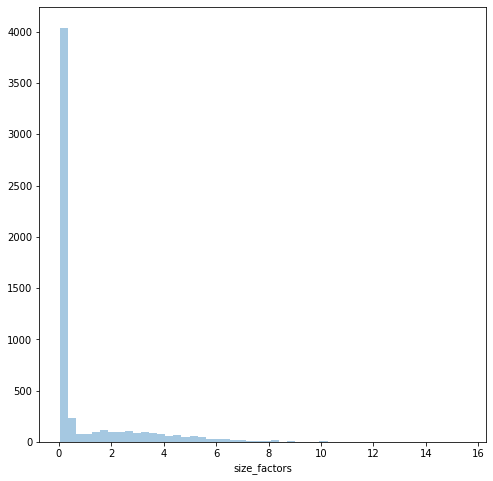

In [76]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors.obs.sizeFactor.values

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(adata.obs['size_factors'], bins=50, kde=False)
plt.show()

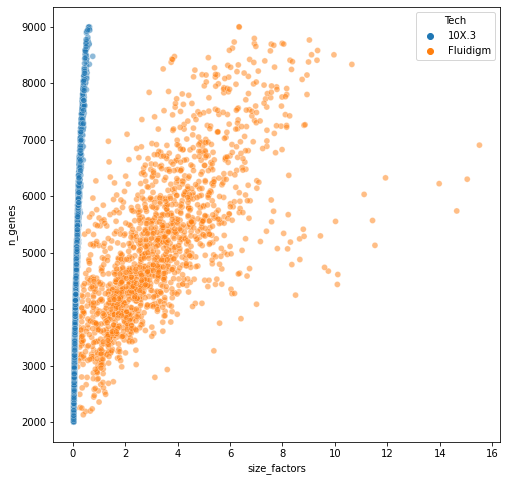

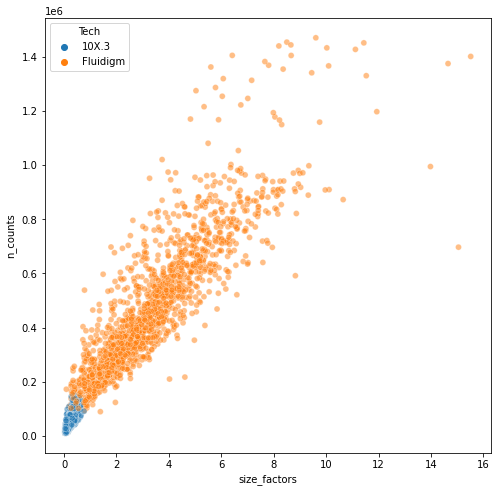

In [77]:
sb.scatterplot(data = adata.obs,x="size_factors",y="n_genes",alpha=0.5,hue="Tech")
plt.show()
sb.scatterplot(data = adata.obs,x="size_factors",y="n_counts",alpha=0.5,hue="Tech")

In [78]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [80]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', 
                            # batch_key = "Tech",
                            n_top_genes=6000)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


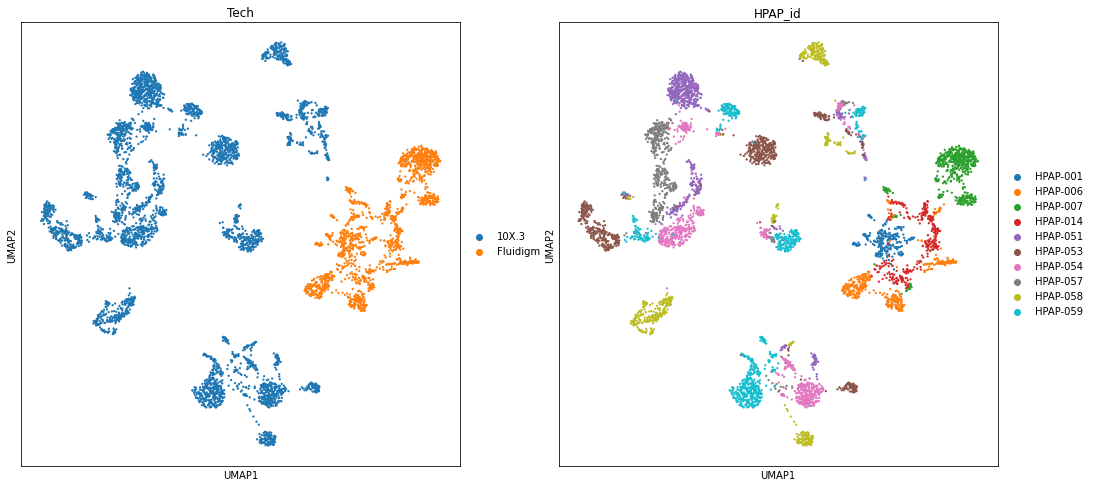

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:03)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


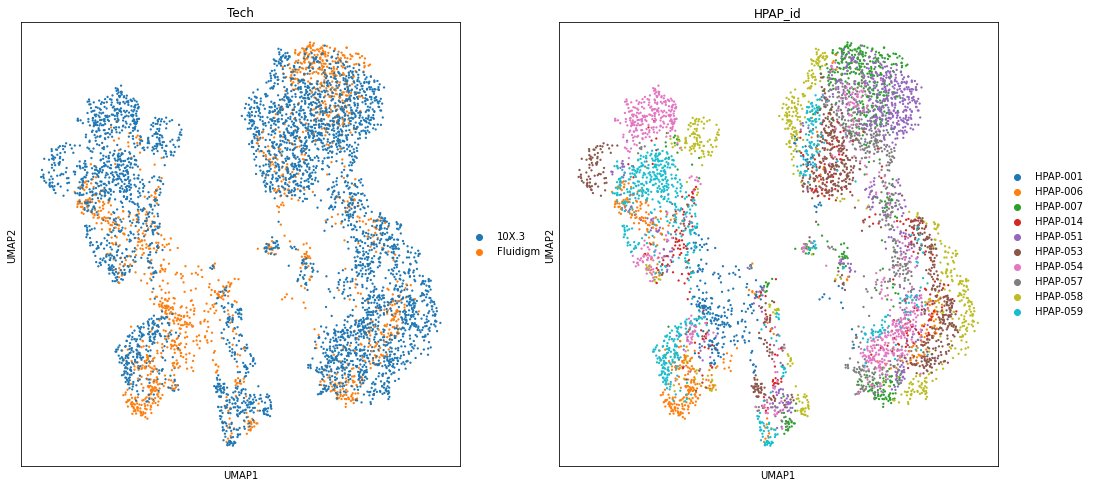

In [81]:
import bbknn
mnn_t2d = adata2bbknnCorrected(adata,6000,"Tech")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


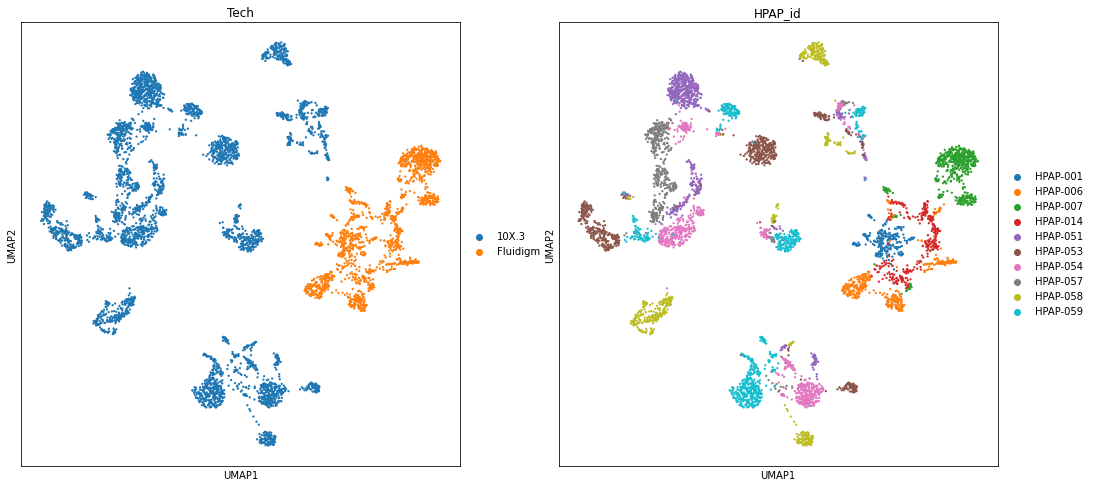

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:03)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


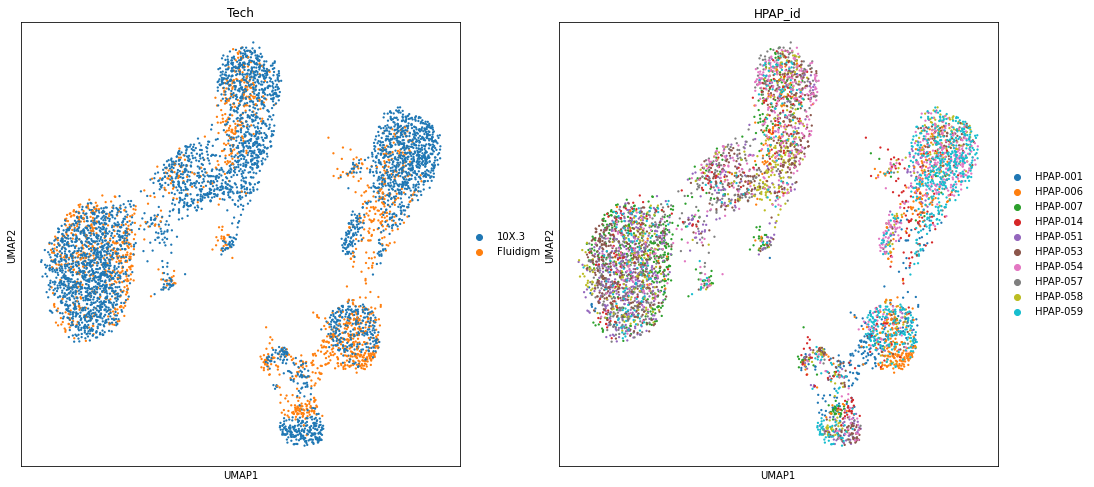

In [82]:
mnn_t2d = adata2bbknnCorrected(adata,6000,"HPAP_id")

to avoid issues related to reproducibility, I load a previously saved object to achieve consistent results in successive iteration of this notebook (and also consistent with the paper results, otherwise there would be small differences in cluster numbering which would be difficult to assign in the notebook)

In [83]:
mnn_t2d = sc.read_h5ad("h5ad/adata_t2d.final.h5ad")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


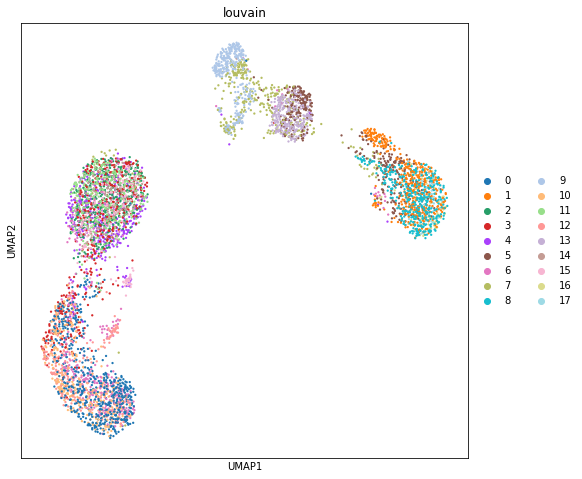

In [85]:
mnn_t2d.obsm["umap"] = mnn_t2d.obsm["UMAP"]
sc.pp.pca(mnn_t2d)
sc.pp.neighbors(mnn_t2d)
louvainAndPlot(mnn_t2d,.3)

running Louvain clustering
    finished: found 27 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


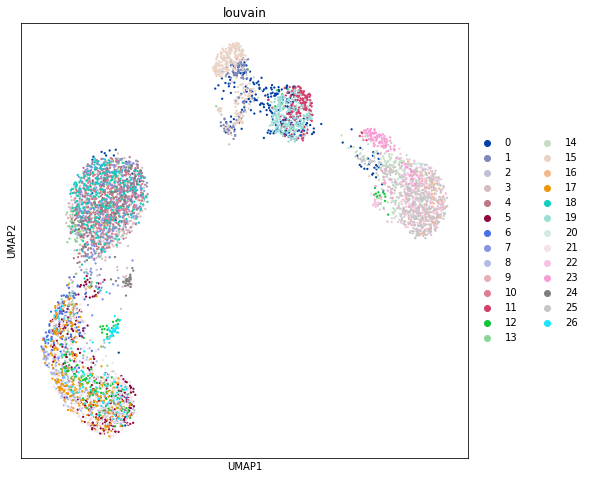

In [86]:
#sc.pp.pca(mnn_t1d)
#sc.pp.neighbors(mnn_t1d)
def louvainAndPlot(adata_,res=0.5,**kwargs):
    adata = adata_.copy()
    sc.tl.louvain(adata,resolution=res,**kwargs)
    sc.pl.umap(adata, color='louvain')

louvainAndPlot(mnn_t2d,.8,flavor="igraph")

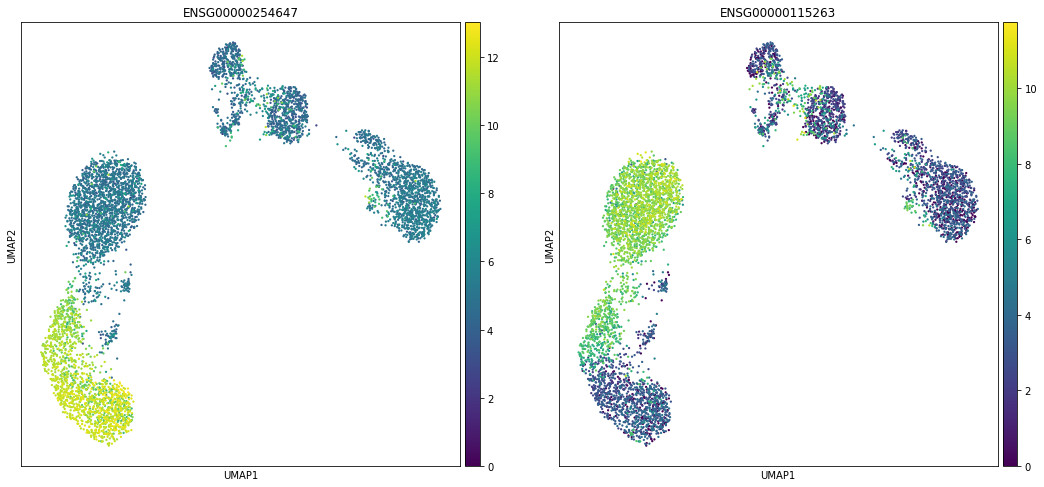

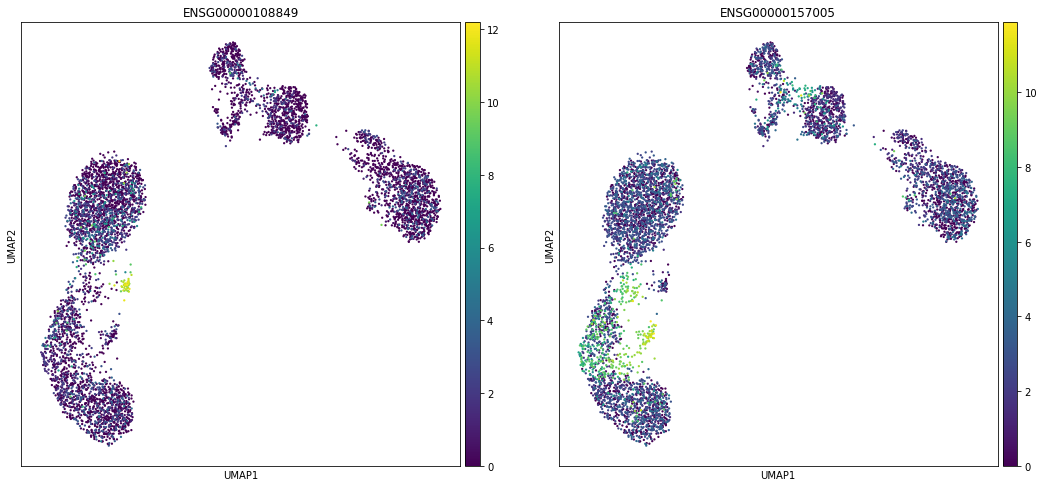

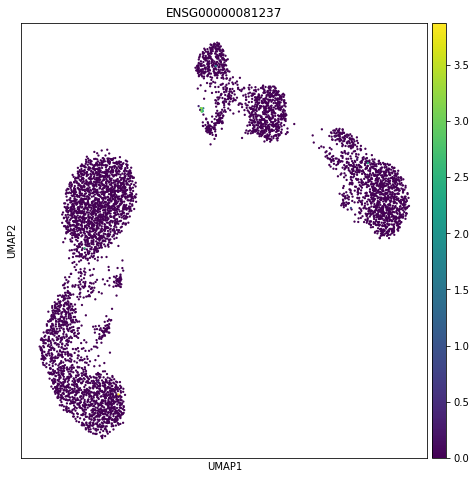

In [87]:
sc.pl.umap(mnn_t2d,color=["ENSG00000254647","ENSG00000115263"])
sc.pl.umap(mnn_t2d,color=["ENSG00000108849","ENSG00000157005"])
sc.pl.umap(mnn_t2d,color=["ENSG00000081237"])


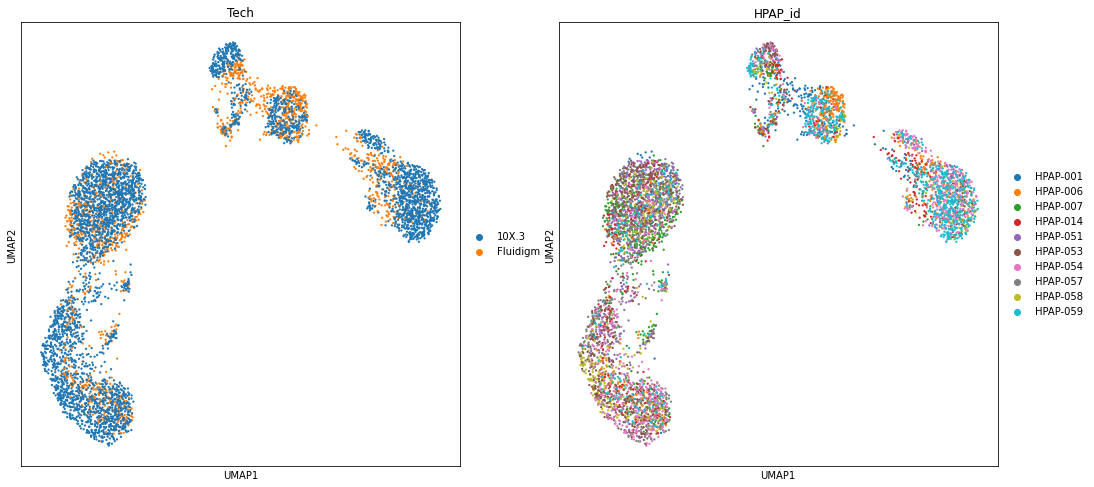

In [88]:
sc.pl.umap(mnn_t2d,color=["Tech","HPAP_id"],save="T2D_confounders.pdf")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell type']`
categories: INS+GCG+, PP, SST+GCG+, etc.
var_group_labels: alpha, beta, PP, etc.


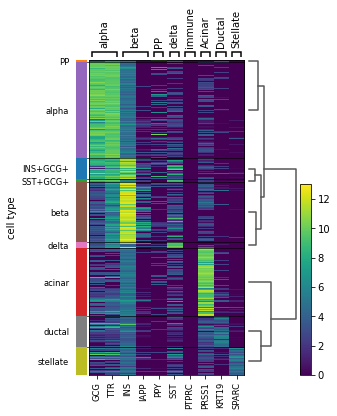

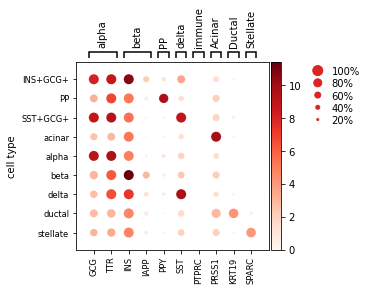

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [90]:
cluster2annotation = {i:v for l,v in zip(\
    *([["2"], # acinar
       ["3,0"], # ductal
       ["3,1","3,2"], # stellate
       ["0-1,0","0-1,1"], # alpha
       ["0-1,2","0-1,3"], # beta
       ["0-1,4"], # DPC alpha beta
       ["0-1,5,1"], # DPC alpha delta
       ["0-1,5,0","0-1,5,0"], # SST
       ["0-1,5,2"]], # PP
      ["acinar","ductal","stellate","alpha","beta","INS+GCG+","SST+GCG+","delta","PP"]))\
                                   for i in l}
mnn_t2d.obs['cell type'] = mnn_t2d.obs['louvain_endo3'].map(cluster2annotation).astype('category')
sc.tl.dendrogram(mnn_t2d,"cell type")
sc.pl.heatmap(mnn_t2d, marker_genes_dict, groupby='cell type', cmap='viridis', 
                   dendrogram=True,gene_symbols="gene_symbols")
sc.pl.dotplot(mnn_t2d, marker_genes_dict,'cell type',gene_symbols="gene_symbols")

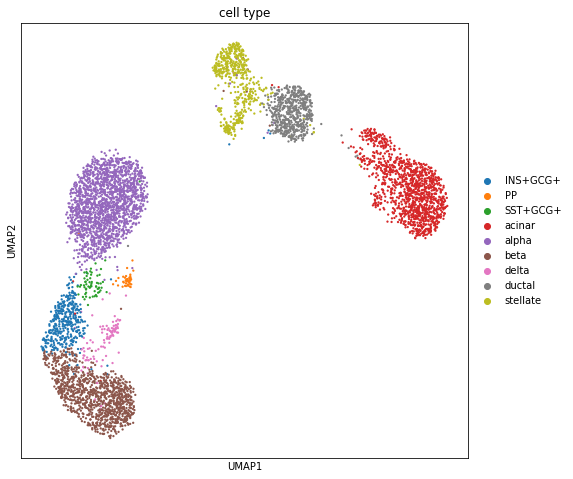

In [91]:
sc.pl.umap(mnn_t2d,color="cell type")

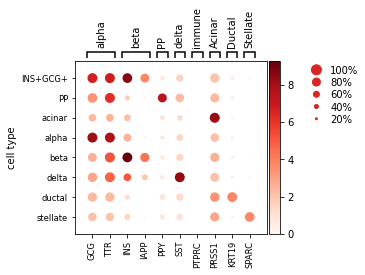

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [69]:
sc.pl.dotplot(mnn_t1d, marker_genes_dict,'cell type',gene_symbols="gene_symbols",save="T1D_cell_type_markers_dotplot.pdf")